In [147]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [72]:
file_path = "../results/results_1x.csv"
results_1x = pd.read_csv("../results/results_1x.csv")
results_1x.head(3)

,Backbone,COCO format,Epochs,Lr initial,Lr step,Batch Size,Best AP,Best AP epoch,Best AR,Best AR epoch
0,DLA,gray,10.0,0.005,0,8.0,0.0012,8.0,0.0075,8.0
1,DLA,gray,10.0,0.005,0,16.0,0.0022,6.0,0.0204,4.0
2,DLA,gray,10.0,0.005,0,32.0,0.0889,2.0,0.1732,2.0


In [73]:
results_1x.dropna(inplace=True)
results_1x["Best AP Epoch"] = pd.to_numeric(results_1x["Best AP epoch"], downcast='integer')
results_1x["Best AR Epoch"] = pd.to_numeric(results_1x["Best AR epoch"], downcast='integer')
results_1x["Batch Size"] =results_1x["Batch Size"].astype(int)

In [74]:
def filter_values(scores,backbone):
    return (scores[(scores["Backbone"]==backbone) & (scores["Lr step"] == '0') & 
                (scores["Epochs"]<20)])

In [161]:
dla_search = filter_values(results_1x,'DLA')
hourglass_search = filter_values(results_1x,'Hourglass')
hrnet_search = filter_values(results_1x,'HRNet')

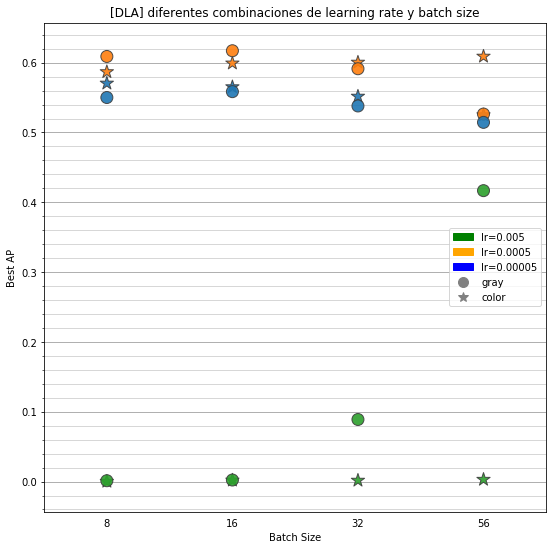

In [198]:
fig, ax = plt.subplots(figsize=(9,9))
sb.stripplot(x='Batch Size',y='Best AP',marker="*",jitter=False,s=14,alpha=0.9,linewidth=1,
           hue='Lr initial',data=dla_search[dla_search['COCO format'] == 'color'],ax=ax)
sb.stripplot(x='Batch Size',y='Best AP',marker="o",jitter=False,s=12,alpha=0.9,linewidth=1,\
           hue='Lr initial',data=dla_search[dla_search['COCO format'] == 'gray'],ax=ax)
orange_patch = mpatches.Patch(color='orange', label='lr=0.0005')
blue_patch = mpatches.Patch(color='blue', label='lr=0.00005')
green_patch = mpatches.Patch(color='green',label='lr=0.005')
color_marker = mlines.Line2D([], [], color='gray', marker='*',linewidth=1,
                     markersize=10, label='color',linestyle='None')
gray_marker = mlines.Line2D([], [], color='gray', marker='o',linewidth=1,
                     markersize=10, label='gray',linestyle='None')
plt.legend(handles=[green_patch,orange_patch,blue_patch,gray_marker,color_marker],loc='center right')
ax.grid(True,which='major',axis='y',linewidth=1.0)
ax.grid(True,which='minor',axis='y',linewidth=0.5)
ax.minorticks_on()
plt.title("[DLA] diferentes combinaciones de learning rate y batch size")
plt.tick_params(axis='x',which='both',bottom=False)
plt.show()

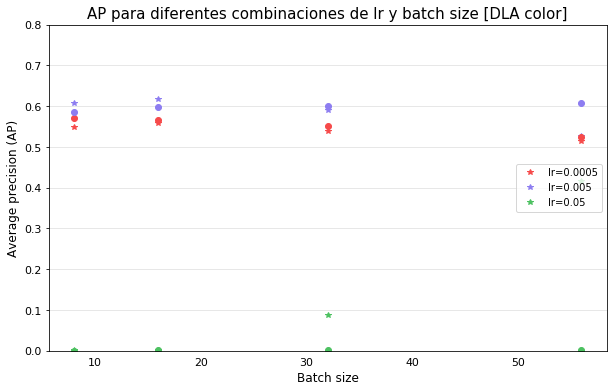

In [102]:
# Average Precision for finetuning over model trained with gray images
ax = plot_lr_search(None,results_1x,"DLA","gray","precision")
plot_lr_search(ax,results_1x,"DLA","color","precision",show=True)
#plot_lr_search(ax,results_1x,"HRNet","gray","precision",show=True)

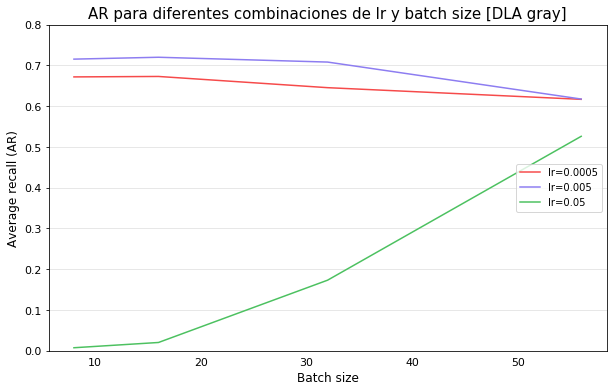

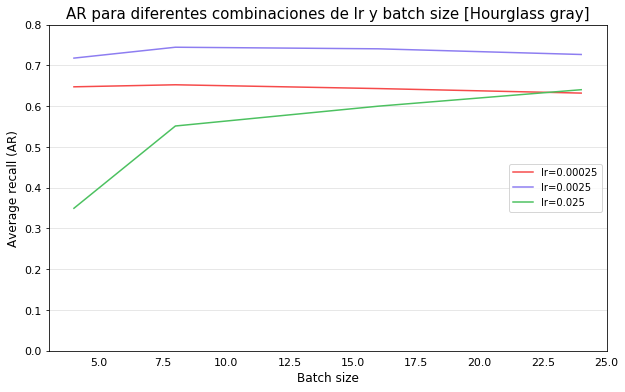

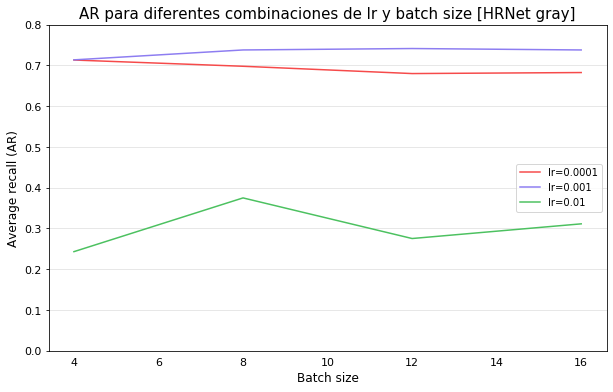

In [8]:
# Average recall for finetuning over model trained with gray images
plot_lr_search(results_1x,"DLA","gray","recall")
plot_lr_search(results_1x,"Hourglass","gray","recall")
plot_lr_search(results_1x,"HRNet","gray","recall")